## Images Clustering

In [13]:
import requests
import os
import re
import json
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from selenium import webdriver
import time
import matplotlib.pyplot as plt
import urllib
%matplotlib inline

In [2]:
headers = {'Accept-Language': 'en',
           'X-FORWARDED-FOR': '2.21.184.0'}

In [42]:
url = 'https://www.imdb.com/search/title/?title_type=feature&release_date=2019-01-01,2019-12-31&num_votes=1000,&countries=us&languages=en'

In [4]:
response = requests.get(url, headers=headers)
print(response.status_code)

200


In [5]:
soup = BeautifulSoup(response.text)

In [10]:
soup.find_all('img', attrs={'class': 'loadlate'})[0]['loadlate']

'https://m.media-amazon.com/images/M/MV5BOTg4ZTNkZmUtMzNlZi00YmFjLTk1MmUtNWQwNTM0YjcyNTNkXkEyXkFqcGdeQXVyNjg2NjQwMDQ@._V1_UX67_CR0,0,67,98_AL_.jpg'

## Functions to implement

* **[v]** get_link_to_next_page
* **[v]** get_links_to_pics
* **[v]** save_image
* **[v]** download_all_posters

In [14]:
def get_link_to_next_page(soup):
    links = soup.find('a', attrs={'class': 'next-page'})
    if not links:
        return None
    return urllib.parse.urljoin(url, links['href'])

In [15]:
get_link_to_next_page(soup)

'https://www.imdb.com/search/title/?title_type=feature&release_date=2019-01-01,2019-12-31&num_votes=1000,&countries=us&languages=en&start=51'

In [20]:
def get_links_to_pics(soup):
    pics = []
    while True:
        links = soup.find_all('img', attrs={'class': 'loadlate'})
        for i in links:
            pics.append(i['loadlate'])
        next_page = get_link_to_next_page(soup)
        if not next_page:
            return pics
        response = requests.get(next_page)
        soup = BeautifulSoup(response.text)
    

In [22]:
links_to_pics = get_links_to_pics(soup)

In [23]:
len(links_to_pics)

558

In [39]:
def save_image(pic_url, save_dir='images'):
    filename = urllib.parse.urlsplit(pic_url).path.split('/')[-1]
    if not save_dir == '' and not os.path.exists(save_dir):
        os.makedirs(save_dir)
    save_path = os.path.join(save_dir, filename)
    with requests.get(pic_url, stream=True) as r:
        with open(save_path, 'wb') as f:
            r.raise_for_status()
            for chunk in r.iter_content():
                f.write(chunk)

In [41]:
def download_all_posters(url, save_dir='images'):
    headers = {'Accept-Language': 'en',
           'X-FORWARDED-FOR': '2.21.184.0'}
    response = requests.get(url, headers=headers)
    assert response.status_code == 200
    soup = BeautifulSoup(response.text)
    links = get_links_to_pics(soup)
    for link in links:
        save_image(link, save_dir)

In [43]:
download_all_posters(url)

In [44]:
from imageio import imread

In [149]:
save_dir = 'images'

In [150]:
pics = os.listdir(save_dir)

In [156]:
for pic in pics:
    if not os.path.isfile(os.path.join(save_dir, pic)):
        del pic

In [157]:
len(pics)

559

In [219]:
images_flattened = []
images_original = []
for pic in pics:
    try:
        image = imread(os.path.join(save_dir, pic))
        images_original.append(image)
        images_flattened.append(image.flatten())
    except:
        print(pic)

.ipynb_checkpoints


In [221]:
images_original[0].shape

(98, 67, 3)

In [234]:
# for i in range(len(images_flattened)):
#     if len(images_flattened[i]) != 19698:
#         del images_flattened[i]

In [226]:
images_flattened = np.array(images_flattened)
images_original = np.array(images_original)

In [121]:
from sklearn import manifold

In [227]:
tsne = manifold.TSNE(n_components=2, init='pca')

In [228]:
X_tsne = tsne.fit_transform(images_flattened)

In [230]:
X_tsne -= X_tsne.min()

In [231]:
X_tsne /= X_tsne.max()

In [239]:
X_tsne

array([[0.2420562 , 0.48662668],
       [0.53194743, 0.46213305],
       [0.03216225, 0.3540251 ],
       ...,
       [0.3799614 , 0.40475145],
       [0.41932398, 0.61399513],
       [0.39257443, 0.52796155]], dtype=float32)

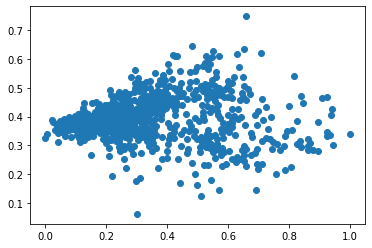

In [232]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])

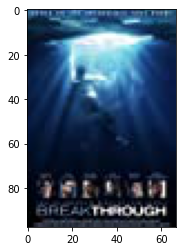

In [233]:
plt.imshow(images_original[0])

In [235]:
from matplotlib import offsetbox

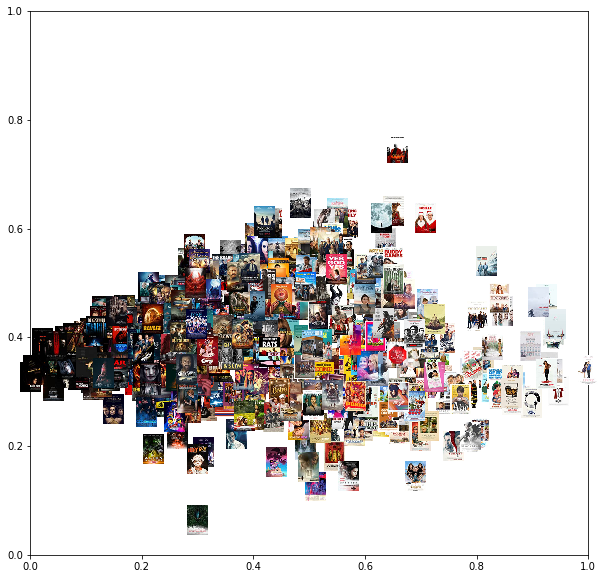

In [246]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
for i in range(len(images_original)):
    imagebox = offsetbox.AnnotationBbox(offsetbox=offsetbox.OffsetImage(images_original[i], zoom=0.3), xy = X_tsne[i],
                                       frameon=False)
    ax.add_artist(imagebox)

In [324]:
rand_int = np.random.randint(len(images_original))
rand_int

195

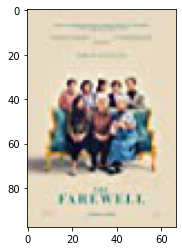

In [325]:
plt.imshow(images_original[rand_int])

In [326]:
def dist(point1, point2):
    return np.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)

In [327]:
dis = [dist(X_tsne[rand_int], point) for point in X_tsne]

(array([16., 34., 47., 71., 57., 80., 90., 84., 56., 22.]),
 array([0.        , 0.08112849, 0.16225699, 0.24338548, 0.32451398,
        0.40564247, 0.48677097, 0.56789946, 0.64902796, 0.73015645,
        0.81128495]),
 <BarContainer object of 10 artists>)

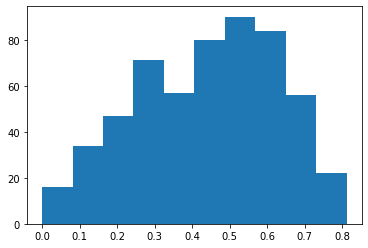

In [328]:
plt.hist(dis)

In [329]:
sum(dis<np.percentile(dis, 5))

28

In [330]:
inds = np.arange(len(images_original))[dis < np.percentile(dis, 5)]

Indices of the closest pictures to the picture above.

In [331]:
inds

array([ 21, 116, 125, 156, 195, 198, 217, 226, 230, 266, 294, 297, 298,
       322, 323, 336, 339, 354, 421, 422, 430, 446, 457, 462, 468, 475,
       523, 549])

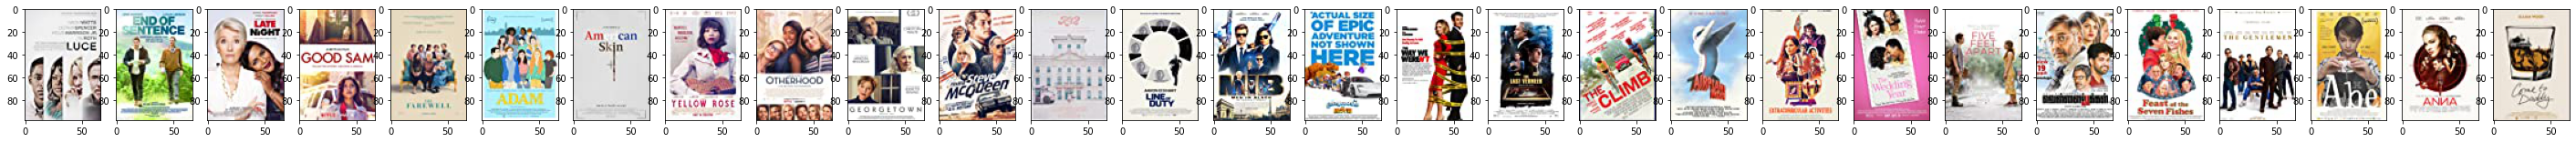

In [332]:
plt.figure(figsize=(50,50))
for i, ind in enumerate(inds):
    plt.subplot(1, len(inds), i+1)
    plt.imshow(images_original[ind])